In [1]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Import necessary libraries [cite: 39]
import pandas as pd
import numpy as np
import os

# 3. Define file paths
# UPDATE THIS PATH to match where you uploaded the files in your Drive
base_path = '/content/drive/MyDrive/Retail_Project/data/'

# 4. Load the data
try:
    df_sales = pd.read_csv(os.path.join(base_path, 'train.csv'), low_memory=False)
    df_store = pd.read_csv(os.path.join(base_path, 'store.csv'))

    print("✅ Data loaded successfully!")
    print(f"Sales Data Shape: {df_sales.shape}")
    print(f"Store Data Shape: {df_store.shape}")

    # Display first few rows to verify
    display(df_sales.head())
    display(df_store.head())

except FileNotFoundError:
    print("❌ Error: Files not found. Please check your base_path variable.")

Mounted at /content/drive
✅ Data loaded successfully!
Sales Data Shape: (1017209, 9)
Store Data Shape: (1115, 10)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [2]:
# --- STEP 2: Data Merging & Cleaning ---

# 1. Convert 'Date' to datetime object (Crucial for time-series)
df_sales['Date'] = pd.to_datetime(df_sales['Date'])

# 2. Merge Sales and Store data
# We assume 'Store' is the common key column
raw_df = pd.merge(df_sales, df_store, on='Store', how='left')

print(f"Shape after merging: {raw_df.shape}")

# 3. Filter: Keep only days where Store is OPEN
# If the store is closed, Sales are 0. We can't learn demand from closed days.
df = raw_df[raw_df['Open'] == 1].copy()

# 4. Filter: Remove rows with 0 Sales if the store was Open (rare edge case)
df = df[df['Sales'] > 0]

print(f"Shape after filtering closed days: {df.shape}")

# 5. Handle Missing Values
# Check missing values
print("\nMissing values before cleaning:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Impute 'CompetitionDistance' with the median (as per docs)
distance_median = df['CompetitionDistance'].median()
df['CompetitionDistance'].fillna(distance_median, inplace=True)

# Fill other missing store metadata with 0 (assuming no competition/promo info means none exists)
# Common pattern in Rossmann dataset for these specific columns:
cols_to_fill_zero = ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
                     'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

for col in cols_to_fill_zero:
    df[col].fillna(0, inplace=True)

print("\n✅ Cleaning complete. Missing values remaining:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Shape after merging: (1017209, 18)
Shape after filtering closed days: (844338, 18)

Missing values before cleaning:
CompetitionDistance            2186
CompetitionOpenSinceMonth    268600
CompetitionOpenSinceYear     268600
Promo2SinceWeek              423292
Promo2SinceYear              423292
PromoInterval                423292
dtype: int64

✅ Cleaning complete. Missing values remaining:


/tmp/ipython-input-2282518241.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CompetitionDistance'].fillna(distance_median, inplace=True)
/tmp/ipython-input-2282518241.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpla

Series([], dtype: int64)


In [3]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [4]:
output_path = os.path.join(base_path, 'df_cleaned.csv')
df.to_csv(output_path, index=False)
print(f"✅ DataFrame saved successfully to: {output_path}")

✅ DataFrame saved successfully to: /content/drive/MyDrive/Retail_Project/data/df_cleaned.csv


In [4]:
# --- STEP 3: Feature Engineering ---

# 1. Date Features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['IsWeekend'] = df['DayOfWeek'] >= 5

# 2. Categorical Encoding
# Map string columns to numbers so the model can read them
store_type_map = {'a': 1, 'b': 2, 'c': 3, 'd': 4}
assortment_map = {'a': 1, 'b': 2, 'c': 3}

df['StoreType'] = df['StoreType'].map(store_type_map)
df['Assortment'] = df['Assortment'].map(assortment_map)

# Handle StateHoliday (it has mixed types like '0' string and 0 integer)
df['StateHoliday'] = df['StateHoliday'].astype(str).apply(lambda x: 1 if x in ['a', 'b', 'c'] else 0)

# 3. Lag and Rolling Features
# CRITICAL: Sort by Store and Date first!
df.sort_values(['Store', 'Date'], inplace=True)

# Group by Store so lags don't mix between different stores
# Lag 1: Sales yesterday (useful if we forecast 1 day ahead)
# Lag 7: Sales same day last week (very strong predictor)
df['Sales_Lag_7'] = df.groupby('Store')['Sales'].shift(7)
df['Sales_Lag_14'] = df.groupby('Store')['Sales'].shift(14)

# Rolling Mean: Average sales of previous 7 days
# Note: We use shift(1) inside rolling to avoid data leakage (using today's sales to predict today)
df['Rolling_Mean_7'] = df.groupby('Store')['Sales'].shift(1).rolling(window=7).mean()

# 4. Drop rows with NaNs created by lags
# (The first 14 days of data for each store won't have a "Lag_14", so we drop them)
df.dropna(inplace=True)

print("✅ Feature Engineering Complete.")
print(f"Final Data Shape: {df.shape}")
print(df[['Date', 'Store', 'Sales', 'Sales_Lag_7', 'Rolling_Mean_7']].head())

✅ Feature Engineering Complete.
Final Data Shape: (828728, 25)
             Date  Store  Sales  Sales_Lag_7  Rolling_Mean_7
997140 2013-01-18      1   4127       4892.0     4484.857143
996025 2013-01-19      1   5182       4881.0     4375.571429
993795 2013-01-21      1   5394       4952.0     4418.571429
992680 2013-01-22      1   5720       4717.0     4481.714286
991565 2013-01-23      1   5578       3900.0     4625.000000


In [9]:
print(df.head())

        Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
997140      1          4 2013-01-18   4127        568     1      0   
996025      1          5 2013-01-19   5182        688     1      0   
993795      1          0 2013-01-21   5394        607     1      1   
992680      1          1 2013-01-22   5720        667     1      1   
991565      1          2 2013-01-23   5578        627     1      1   

        StateHoliday  SchoolHoliday  StoreType  ...  Promo2SinceWeek  \
997140             0              0          3  ...              0.0   
996025             0              0          3  ...              0.0   
993795             0              0          3  ...              0.0   
992680             0              0          3  ...              0.0   
991565             0              0          3  ...              0.0   

        Promo2SinceYear  PromoInterval  Year  Month  Day  IsWeekend  \
997140              0.0              0  2013      1   18      False   
9960

In [5]:
# --- STEP 4: Model Training & Evaluation ---

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 1. Define Features (X) and Target (y)
# Exclude 'Customers' (unknown future), 'Date' (datetime), 'Open' (always 1), and target 'Sales'
features = ['Store', 'DayOfWeek', 'Promo', 'SchoolHoliday', 'CompetitionDistance',
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
            'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
            'IsWeekend', 'StoreType', 'Assortment', 'StateHoliday',
            'Sales_Lag_7', 'Sales_Lag_14', 'Rolling_Mean_7']

target = 'Sales'

# 2. Time-Based Train/Validation Split
# We'll use the last ~6 weeks of data for validation to simulate "future" prediction
split_date = '2015-06-15'

train = df[df['Date'] < split_date].copy()
val = df[df['Date'] >= split_date].copy()

print(f"Training Range: {train['Date'].min()} to {train['Date'].max()}")
print(f"Validation Range: {val['Date'].min()} to {val['Date'].max()}")

X_train, y_train = train[features], train[target]
X_val, y_val = val[features], val[target]

# 3. Train XGBoost Model
print("\n⏳ Training XGBoost model... (this may take 2-3 minutes)")
model = xgb.XGBRegressor(
    n_estimators=1000,      # Number of trees
    learning_rate=0.1,      # Step size
    max_depth=7,            # Depth of trees (controls complexity)
    random_state=42,
    n_jobs=-1,              # Use all CPU cores
    early_stopping_rounds=50 # Stop if validation score doesn't improve
)

# Use eval_set to monitor performance during training
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100
)

# 4. Evaluation
print("\n✅ Training Complete. Evaluating...")
preds = model.predict(X_val)

# Calculate Metrics
rmse = np.sqrt(mean_squared_error(y_val, preds))
mape = mean_absolute_percentage_error(y_val, preds)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2%}")

# 5. Save the Model
# We need this file for the local Streamlit app later
import joblib
model_path = '/content/drive/MyDrive/Retail_Project/model_xgb.pkl'
joblib.dump(model, model_path)
print(f"\nModel saved to: {model_path}")

Training Range: 2013-01-15 00:00:00 to 2015-06-14 00:00:00
Validation Range: 2015-06-15 00:00:00 to 2015-07-31 00:00:00

⏳ Training XGBoost model... (this may take 2-3 minutes)
[0]	validation_0-rmse:2864.06082	validation_1-rmse:2848.08298
[100]	validation_0-rmse:980.20814	validation_1-rmse:1104.69218
[200]	validation_0-rmse:890.07535	validation_1-rmse:1054.96049
[300]	validation_0-rmse:826.21051	validation_1-rmse:1024.79796
[400]	validation_0-rmse:784.04767	validation_1-rmse:1000.31410
[500]	validation_0-rmse:752.06384	validation_1-rmse:984.94063
[600]	validation_0-rmse:728.02621	validation_1-rmse:971.78800
[700]	validation_0-rmse:709.91504	validation_1-rmse:965.44901
[800]	validation_0-rmse:693.50385	validation_1-rmse:958.92225
[900]	validation_0-rmse:680.99454	validation_1-rmse:954.44679
[999]	validation_0-rmse:669.06950	validation_1-rmse:948.20525

✅ Training Complete. Evaluating...
RMSE: 948.21
MAPE: 9.43%

Model saved to: /content/drive/MyDrive/Retail_Project/model_xgb.pkl


In [13]:
print(train.size)

19571900


In [14]:
print(val.size)

1146300


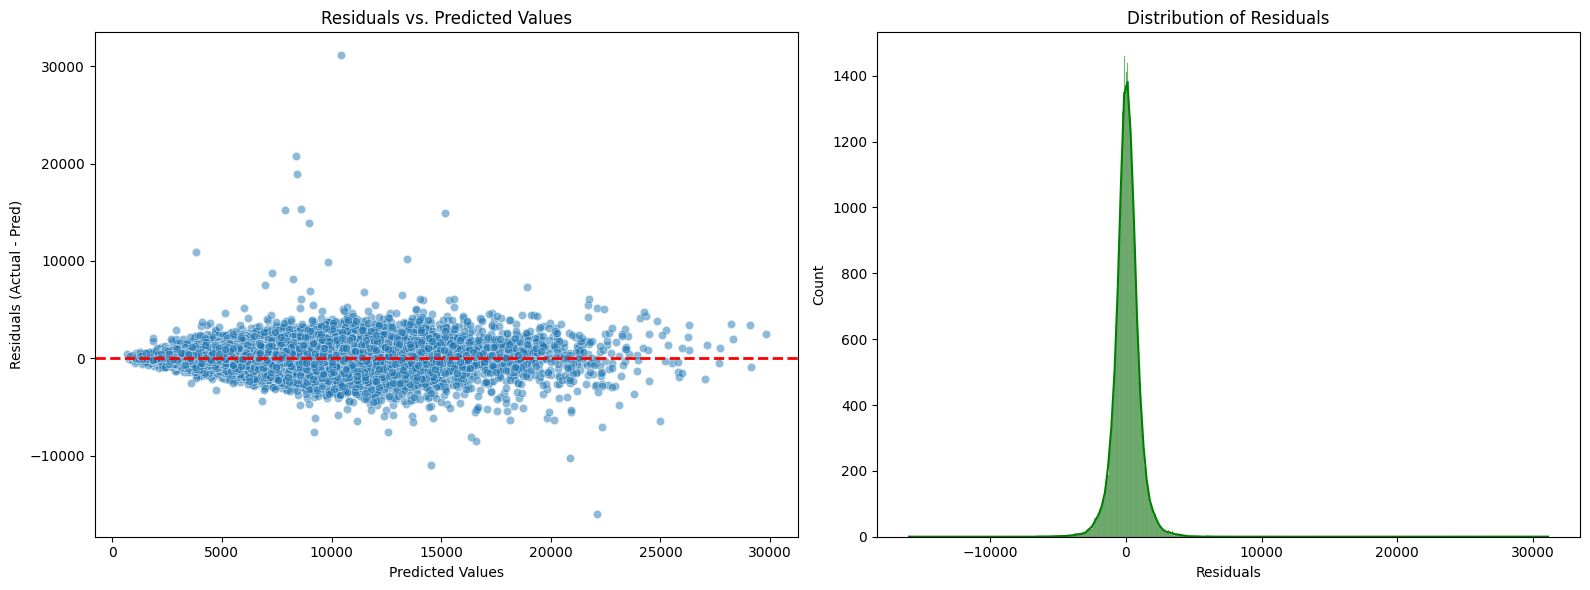

Your Model RMSE:   948.21
Naive Baseline RMSE: 3089.16
✅ Your model is performing better than the naive baseline.

--- Top 5 Worst Predictions ---
       Actual     Predicted     Abs_Error     Residuals
44393   41551  10430.439453  31120.560547  31120.560547
35971   29161   8389.469727  20771.530273  20771.530273
28750   27330   8409.083984  18920.916016  18920.916016
36588    6125  22106.035156  15981.035156 -15981.035156
27635   23927   8598.865234  15328.134766  15328.134766


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ---------------------------------------------------------
# REPLACE THESE WITH YOUR ACTUAL VARIABLES
# Example: y_test = df_test['target']
#          y_pred = model.predict(X_test)
# ---------------------------------------------------------
# Assuming y_test and y_pred are already defined in your environment:
results = pd.DataFrame({
    'Actual': y_val,
    'Predicted': preds
})
# ---------------------------------------------------------

# 1. Calculate Residuals
results['Residuals'] = results['Actual'] - results['Predicted']
results['Abs_Error'] = results['Residuals'].abs()

# 2. Visualization
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot A: Residual Plot (Homoscedasticity Check)
# We want to see a cloud of random dots. If you see a "funnel" shape,
# it means errors grow as the predicted value grows.
sns.scatterplot(x='Predicted', y='Residuals', data=results, alpha=0.5, ax=ax[0])
ax[0].axhline(0, color='r', linestyle='--', linewidth=2)
ax[0].set_title('Residuals vs. Predicted Values')
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('Residuals (Actual - Pred)')

# Plot B: Error Distribution (Normality Check)
# We want a bell curve centered at 0. Skewness indicates bias.
sns.histplot(results['Residuals'], kde=True, ax=ax[1], color='g')
ax[1].set_title('Distribution of Residuals')

plt.tight_layout()
plt.show()

# 3. Validation Metrics
# Naive Baseline: What if we just predicted the average every time?
naive_rmse = np.sqrt(np.mean((results['Actual'] - results['Actual'].mean())**2))
current_rmse = np.sqrt(np.mean(results['Residuals']**2))

print(f"Your Model RMSE:   {current_rmse:.2f}")
print(f"Naive Baseline RMSE: {naive_rmse:.2f}")

if current_rmse < naive_rmse:
    print("✅ Your model is performing better than the naive baseline.")
else:
    print("⚠️ Warning: Your model is worse than just guessing the average.")

# 4. Inspect the Worst Failures
print("\n--- Top 5 Worst Predictions ---")
print(results.sort_values('Abs_Error', ascending=False).head(5)[['Actual', 'Predicted', 'Abs_Error', 'Residuals']])

In [11]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 1. Transform your Training Target
# We use log1p (log(1+x)) instead of log(x) to avoid errors if you have 0s.
y_train_log = np.log1p(y_train) ### CRITICAL STEP 1: Compress the target

# Also transform the validation target for early stopping evaluation
y_val_log = np.log1p(y_val)

# 2. Train your Model
# (Use your existing model code here, but fit it to y_train_log)
print("\n⏳ Re-training XGBoost model with log-transformed target...")
model.fit(
    X_train, y_train_log,
    eval_set=[(X_train, y_train_log), (X_val, y_val_log)], # CRITICAL FIX: Add eval_set with log-transformed validation target
    verbose=100
)

# 3. Predict (The output will now be in 'Log' scale)
y_pred_log = model.predict(X_val) # Changed X_test to X_val for consistency

# 4. Reverse the Transformation
# We must convert the predictions back to the original scale ($) to evaluate.
y_pred_final = np.expm1(y_pred_log) ### CRITICAL STEP 2: Expand back to real numbers

# 5. Evaluate
# Calculate RMSE on the REAL numbers, not the log numbers
rmse_new = np.sqrt(mean_squared_error(y_val, y_pred_final)) # Changed y_test to y_val
mape_new = mean_absolute_percentage_error(y_val, y_pred_final) # Changed y_test to y_val

print(f"Original RMSE: {rmse:.2f}") # Using the previously calculated RMSE for comparison
print(f"New RMSE:      {rmse_new:.2f}")
print(f"New MAPE:      {mape_new:.2%}")

# 6. Spot Check the "High Value" Failures
# Let's see if it can now predict closer to those 40k values
results_log = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred_final}) # Changed y_test to y_val
results_log['Abs_Error'] = (results_log['Actual'] - results_log['Predicted']).abs()

print("\n--- New Top 5 Worst Predictions ---")
print(results_log.sort_values('Abs_Error', ascending=False).head(5))


⏳ Re-training XGBoost model with log-transformed target...
[0]	validation_0-rmse:0.39279	validation_1-rmse:0.38160
[100]	validation_0-rmse:0.14183	validation_1-rmse:0.14358
[200]	validation_0-rmse:0.12630	validation_1-rmse:0.13646
[300]	validation_0-rmse:0.11779	validation_1-rmse:0.13260
[400]	validation_0-rmse:0.11227	validation_1-rmse:0.13050
[500]	validation_0-rmse:0.10822	validation_1-rmse:0.12929
[600]	validation_0-rmse:0.10504	validation_1-rmse:0.12743
[696]	validation_0-rmse:0.10267	validation_1-rmse:0.12721
Original RMSE: 948.21
New RMSE:      980.44
New MAPE:      9.68%

--- New Top 5 Worst Predictions ---
       Actual     Predicted     Abs_Error
44393   41551  10354.722656  31196.277344
35971   29161   7825.353027  21335.646973
28750   27330   8166.610840  19163.389160
43278   30038  12412.375977  17625.624023
36588    6125  22520.664062  16395.664062


In [16]:
import pandas as pd

# 1. Identify the Index of the Worst Predictions
# (Assuming 'results' is your dataframe from the previous step)
worst_indices = results.sort_values('Abs_Error', ascending=False).head(5).index

# 2. Extract the Feature Data (X_test) for these specific rows
# Replace 'X_test' with your actual features dataframe
bad_rows_features = X_val.loc[worst_indices]

# 3. Calculate the Average Feature values for the whole dataset (as a baseline)
average_features = X_val.mean().to_frame(name='Dataset_Average').T

# 4. Combine them for side-by-side comparison
comparison = pd.concat([bad_rows_features, average_features])

# 5. Highlight significant differences
# This calculates how different the "bad" rows are from the average (in percentage)
diff_matrix = (bad_rows_features - X_val.mean()) / X_val.mean() * 100

print("--- Feature Values for the Worst Predictions vs Average ---")
# displaying the transpose makes it easier to read if you have many features
print(comparison.T.to_markdown())

print("\n--- Percentage Deviation from Average (What made these rows different?) ---")
# Look for features with huge % changes (e.g., +500%)
print(diff_matrix.T.to_markdown())

--- Feature Values for the Worst Predictions vs Average ---
|                           |   44393 |   35971 |   28750 |   36588 |   27635 |   Dataset_Average |
|:--------------------------|--------:|--------:|--------:|--------:|--------:|------------------:|
| Store                     |     909 |  292    |   876   |   909   |   876   |        558.078    |
| DayOfWeek                 |       0 |    0    |     0   |     0   |     1   |          2.45394  |
| Promo                     |       0 |    1    |     0   |     1   |     0   |          0.485715 |
| SchoolHoliday             |       0 |    0    |     0   |     0   |     0   |          0.290151 |
| CompetitionDistance       |    1680 | 1100    | 21790   |  1680   | 21790   |       5425.53     |
| CompetitionOpenSinceMonth |       0 |    6    |     4   |     0   |     4   |          4.93239  |
| CompetitionOpenSinceYear  |       0 | 2009    |  2005   |     0   |  2005   |       1370.7      |
| Promo2                    |       1 | 

In [17]:
# 1. Store Anchor (What does THIS store usually do on this day?)
# We group by Store and DayOfWeek to get the specific baseline.
store_day_avg = df.groupby(['Store', 'DayOfWeek'])['Sales'].mean().reset_index()
store_day_avg.columns = ['Store', 'DayOfWeek', 'Store_DayOfWeek_Avg']

# Merge this back into your main dataframe
df = pd.merge(df, store_day_avg, on=['Store', 'DayOfWeek'], how='left')

# 2. Relative Momentum (Acceleration)
# Ensure data is sorted by Date/Store before rolling
df = df.sort_values(['Store', 'Date'])

# We need a 30-day window to compare against the 7-day window
# (Assuming you already have Rolling_Mean_7 calculated)
df['Rolling_Mean_30'] = df.groupby('Store')['Sales'].transform(lambda x: x.shift(1).rolling(window=30).mean())

# The Ratio: Is short-term > long-term?
df['Momentum_7_vs_30'] = df['Rolling_Mean_7'] / df['Rolling_Mean_30']

# Fill NaNs created by the lag (first 30 days will be empty)
df.fillna(0, inplace=True)

print("Features Added: 'Store_DayOfWeek_Avg', 'Momentum_7_vs_30'")

Features Added: 'Store_DayOfWeek_Avg', 'Momentum_7_vs_30'


In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# 1. Update Feature List
# Make sure to include the new column names
features = [
    'Store', 'DayOfWeek', 'Promo', 'SchoolHoliday', 'CompetitionDistance',
    'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
    'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
    'IsWeekend', 'StoreType', 'Assortment',
    'Sales_Lag_7', 'Sales_Lag_14', 'Rolling_Mean_7',
    'Store_DayOfWeek_Avg', 'Momentum_7_vs_30'  # <--- The New Features
]

# 2. Prepare X_train / X_val / X_test with new features
# Re-split the df (which now contains new features) into train and validation sets.
split_date = '2015-06-15'

train_df = df[df['Date'] < split_date].copy()
val_df   = df[df['Date'] >= split_date].copy()

X_train, y_train = train_df[features], train_df['Sales']
X_val, y_val = val_df[features], val_df['Sales'] # <--- Recreated X_val and y_val

# We'll use X_val and y_val for evaluation and also as X_test and y_test for final metrics
X_test = X_val
y_test = y_val

# 3. Train (Using Log Transform as established earlier)
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val) # Need log-transformed y_val for eval_set

# Initialize your model (using same params as before for fair comparison)
# model = XGBRegressor(...)
model.fit(
    X_train, y_train_log,
    eval_set=[(X_train, y_train_log), (X_val, y_val_log)], # Added eval_set with newly created X_val, y_val_log
    verbose=100
)

# 4. Predict & Inverse Transform
y_pred_log = model.predict(X_test)
y_pred_final = np.expm1(y_pred_log)

# 5. Evaluate
rmse_latest = np.sqrt(mean_squared_error(y_test, y_pred_final))
mape_latest = np.mean(np.abs((y_test - y_pred_final) / y_test)) * 100

print(f"Previous Best RMSE: 980.44")
print(f"New RMSE:           {rmse_latest:.2f}")
print(f"New MAPE:           {mape_latest:.2f}%")

# 6. Check the 'Problem Rows' again
# We look at the same indices as before to see if prediction improved
results_latest = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_final})
results_latest['Abs_Error'] = (results_latest['Actual'] - results_latest['Predicted']).abs()

print("\n--- New Top 5 Worst Predictions (Did we fix the 41k miss?) ---")
print(results_latest.sort_values('Abs_Error', ascending=False).head(5))

[0]	validation_0-rmse:0.38899	validation_1-rmse:0.37867
[100]	validation_0-rmse:0.11107	validation_1-rmse:0.12418
[200]	validation_0-rmse:0.10363	validation_1-rmse:0.12330
[248]	validation_0-rmse:0.10163	validation_1-rmse:0.12383
Previous Best RMSE: 980.44
New RMSE:           957.28
New MAPE:           9.44%

--- New Top 5 Worst Predictions (Did we fix the 41k miss?) ---
        Actual     Predicted     Abs_Error
674911   41551  10054.659180  31496.340820
674912   30038   9408.041992  20629.958008
215741   29161   8883.750000  20277.250000
651091   27330   9018.656250  18311.343750
674921   23081   8603.064453  14477.935547


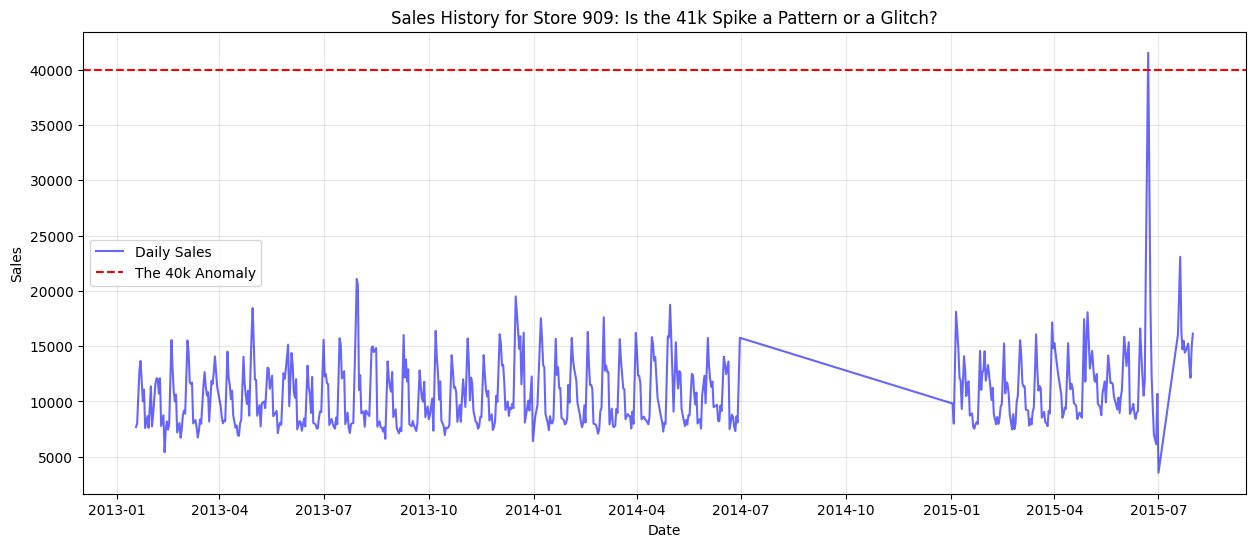

Max Sales ever seen for Store 909: 41551
Number of days Store 909 sold > 20k: 6


In [21]:
import matplotlib.pyplot as plt

# Filter for the specific store that is causing the biggest error
store_id = 909 # From your "Worst Predictions" table
store_data = df[df['Store'] == store_id].sort_values('Date')

plt.figure(figsize=(15, 6))

# Plot Sales history
plt.plot(store_data['Date'], store_data['Sales'], label='Daily Sales', color='blue', alpha=0.6)

# Highlight the specific day of failure
# (Replace with the approximate date of the failure if you know it,
# or we just look for the spike visually)
plt.axhline(y=40000, color='r', linestyle='--', label='The 40k Anomaly')

plt.title(f'Sales History for Store {store_id}: Is the 41k Spike a Pattern or a Glitch?')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Quick Stat Check
print(f"Max Sales ever seen for Store {store_id}: {store_data['Sales'].max()}")
print(f"Number of days Store {store_id} sold > 20k: {len(store_data[store_data['Sales'] > 20000])}")

In [23]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# 1. Define the Outlier Threshold per Store
# We calculate the Mean and Std Dev for EACH store individually.
store_stats = train_df.groupby('Store')['Sales'].agg(['mean', 'std']).reset_index()
store_stats['Outlier_Limit'] = store_stats['mean'] + (3 * store_stats['std']) # 3 Sigma Rule

# 2. Merge stats back to Training Data
train_clean = pd.merge(train_df, store_stats[['Store', 'Outlier_Limit']], on='Store', how='left')

# 3. The Purge: Filter out rows where Sales > Limit
original_len = len(train_clean)
train_clean = train_clean[train_clean['Sales'] <= train_clean['Outlier_Limit']]
new_len = len(train_clean)
print(f"Purged {original_len - new_len} extreme outliers from the Training Set.")

# 4. Re-Train (On Cleaned Data)
# Prepare features
features = [
    'Store', 'DayOfWeek', 'Promo', 'SchoolHoliday', 'CompetitionDistance',
    'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
    'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
    'IsWeekend', 'StoreType', 'Assortment',
    'Sales_Lag_7', 'Sales_Lag_14', 'Rolling_Mean_7',
    'Store_DayOfWeek_Avg', 'Momentum_7_vs_30'
]

X_train_clean = train_clean[features]
y_train_clean = np.log1p(train_clean['Sales']) # Still using Log Transform!

# 5. Predict on the (Dirty) Test Set
# We want to see how it performs on the REAL test data, outliers and all.
X_test = test_df[features]
y_test = test_df['Sales']

# Retrain the model
model.fit(
    X_train_clean, y_train_clean,
    eval_set=[(X_test, np.log1p(y_test))], # Add eval_set here for early stopping
    verbose=100 # Keep verbose for early stopping output
)

y_pred_log = model.predict(X_test)
y_pred_final = np.expm1(y_pred_log)

# 6. Final Evaluation
rmse_clean = np.sqrt(mean_squared_error(y_test, y_pred_final))
mape_clean = np.mean(np.abs((y_test - y_pred_final) / y_test)) * 100

print(f"\n--- Results after Outlier Removal ---")
print(f"Previous Best RMSE: 957.28")
print(f"New RMSE:           {rmse_clean:.2f}")
print(f"New MAPE:           {mape_clean:.2f}%")

# 7. Did the predictions for the 'Worst Rows' change?
# (We expect the model to be more confident on normal days,
# even if it still misses the 41k spike).
results_clean = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_final})
results_clean['Abs_Error'] = (results_clean['Actual'] - results_clean['Predicted']).abs()

print("\n--- Top 5 Worst Predictions (Post-Purge) ---")
print(results_clean.sort_values('Abs_Error', ascending=False).head(5))

Purged 6223 extreme outliers from the Training Set.
[0]	validation_0-rmse:0.37925
[100]	validation_0-rmse:0.12297
[176]	validation_0-rmse:0.12198

--- Results after Outlier Removal ---
Previous Best RMSE: 957.28
New RMSE:           935.31
New MAPE:           9.25%

--- Top 5 Worst Predictions (Post-Purge) ---
        Actual     Predicted     Abs_Error
674911   41551  10239.093750  31311.906250
674912   30038   9332.381836  20705.618164
215741   29161   8769.409180  20391.590820
651091   27330   9211.318359  18118.681641
674921   23081   8604.656250  14476.343750


In [24]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# 1. Define the Parameter Grid
# We test 3 depths and 3 learning rates = 9 combinations
param_grid = {
    'max_depth': [5, 7, 9],           # Controls complexity
    'learning_rate': [0.01, 0.05, 0.1], # Controls step size
    'n_estimators': [1000]            # Keep this high enough to let low learning rates work
}

# 2. Initialize the Model
# n_jobs=-1 uses all your CPU cores to speed this up
xgb_model = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)

# 3. Setup the Grid Search
# cv=3 means "3-Fold Cross Validation" (Train on 2/3, Test on 1/3, repeat 3 times)
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error', # Sklearn uses negative RMSE for optimization
    cv=3,
    verbose=1
)

print("Starting Grid Search... (This may take a few minutes)")

# 4. Fit on your CLEAN training data (Log Transformed)
# Important: We use X_train_clean and y_train_clean from the "Purge" step
grid_search.fit(X_train_clean, y_train_clean)

# 5. Get the Winner
best_params = grid_search.best_params_
best_score = -grid_search.best_score_ # Convert back to positive RMSE (Log scale)

print(f"\nBest Parameters Found: {best_params}")
print(f"Best CV Score (Log RMSE): {best_score:.4f}")

# 6. Final Validation on Test Set using the Winner
best_model = grid_search.best_estimator_

# Predict
y_pred_log = best_model.predict(X_test)
y_pred_final = np.expm1(y_pred_log)

# Evaluate
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_mape = np.mean(np.abs((y_test - y_pred_final) / y_test)) * 100

print(f"\n--- Final Optimized Results ---")
print(f"Previous Best RMSE: 935.31")
print(f"Final RMSE:         {final_rmse:.2f}")
print(f"Final MAPE:         {final_mape:.2f}%")

Starting Grid Search... (This may take a few minutes)
Fitting 3 folds for each of 9 candidates, totalling 27 fits

Best Parameters Found: {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 1000}
Best CV Score (Log RMSE): 0.1078

--- Final Optimized Results ---
Previous Best RMSE: 935.31
Final RMSE:         896.67
Final MAPE:         8.82%


/tmp/ipython-input-1211311358.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


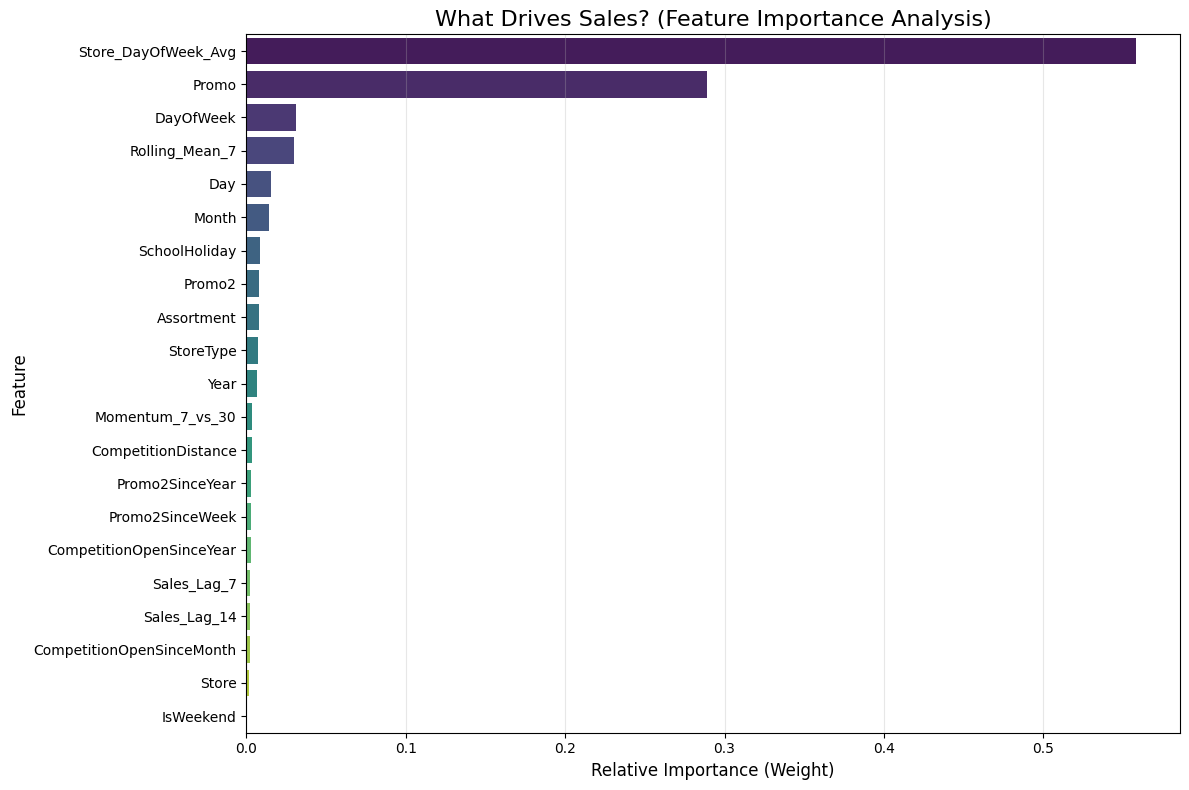


--- The Top 5 Drivers of Sales ---
| Feature             |   Importance |
|:--------------------|-------------:|
| Store_DayOfWeek_Avg |    0.55787   |
| Promo               |    0.288962  |
| DayOfWeek           |    0.0310126 |
| Rolling_Mean_7      |    0.0301769 |
| Day                 |    0.0156605 |


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get Feature Importances from the best model
# The grid search stores the best estimator in .best_estimator_
importances = best_model.feature_importances_
feature_names = X_train_clean.columns

# 2. Create a DataFrame for easier plotting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 3. Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')

plt.title('What Drives Sales? (Feature Importance Analysis)', fontsize=16)
plt.xlabel('Relative Importance (Weight)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Print the Top 5
print("\n--- The Top 5 Drivers of Sales ---")
print(feature_importance_df.head(5).to_markdown(index=False))